# Классификация марки авто по изображениям
Основная идея решения: взять предобученую на ImageNet сеть

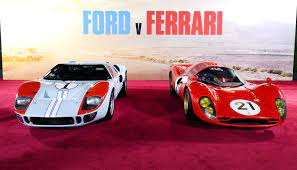


In [1]:
!pip uninstall numpy tensorflow-estimator tensorflow -y
!pip install "numpy<1.19.0" "tensorflow-estimator<2.4.0,>=2.3.0" "tensorflow<2.4"

!pip install -q efficientnet
!pip install albumentations
!pip install efficientnet
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Found existing installation: numpy 1.18.5
Uninstalling numpy-1.18.5:
  Successfully uninstalled numpy-1.18.5
Found existing installation: tensorflow-estimator 2.3.0
Uninstalling tensorflow-estimator-2.3.0:
  Successfully uninstalled tensorflow-estimator-2.3.0
Found existing installation: tensorflow 2.3.2
Uninstalling tensorflow-2.3.2:
  Successfully uninstalled tensorflow-2.3.2
  Using cached numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached tensorflow-2.3.2-cp36-cp36m-manylinux2010_x86_64.whl (320.4 MB)
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-wwg__l3n
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-wwg__l3n
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ngr6805q
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ngr6805q


In [1]:
!nvidia-smi

Mon Apr 26 13:42:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:00:06.0 Off |                  N/A |
|  0%   25C    P5    15W / 180W |      0MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Библиотеки¶

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import zipfile
import csv
import sys
import os


from tensorflow.keras.layers import *
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import efficientnet.tfkeras as efn


from tensorflow.keras.layers import *
from skimage import io
 
    
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.6.9 (default, Jan 26 2021, 15:33:00) 
Numpy        : 1.18.5
Tensorflow   : 2.3.2
Keras        : 2.4.0


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip freeze > requirements.txt

## Предобработка

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = "iuliiazavgorodniaia"
os.environ['KAGGLE_KEY'] = "b2261bea0ef4aee05345cac43ae51992"
!kaggle competitions download -c sf-dl-car-classification --force

  3%|█▏                                    | 49.0M/1.58G [00:01<00:30, 54.0MB/s]^C
  4%|█▌                                    | 64.0M/1.58G [00:01<00:34, 46.8MB/s]
User cancelled operation


In [ ]:
!unzip -q sf-dl-car-classification.zip
!unzip -q test.zip
!unzip -q train.zip

In [17]:
import glob
files = glob.glob('train/*/*.jpg')


## Основные настройки

In [6]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 10  # эпох на обучение
BATCH_SIZE = 16  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 0.001 # lerning rate
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 224  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

part = 'Xception'  # Версия эксперимента

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

In [7]:
# Графики
def make_graf(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## EDA / Анализ данных

In [8]:
train_df = pd.read_csv("train.csv")
sample_submission = pd.read_csv("sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

### Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


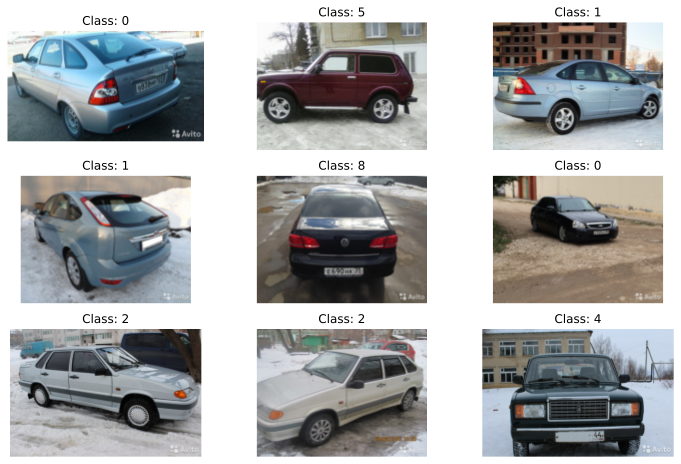

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

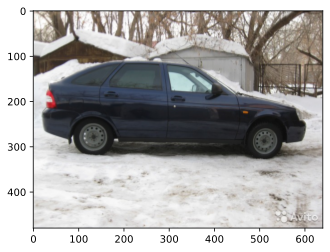

(640, 480)

In [11]:
image = PIL.Image.open('train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
Аугментация данных

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

## Генерация данных

In [97]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    '/work/train',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    '/work/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe = sample_submission,
    directory='/work/test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим результат

Пример картинок из train_generator


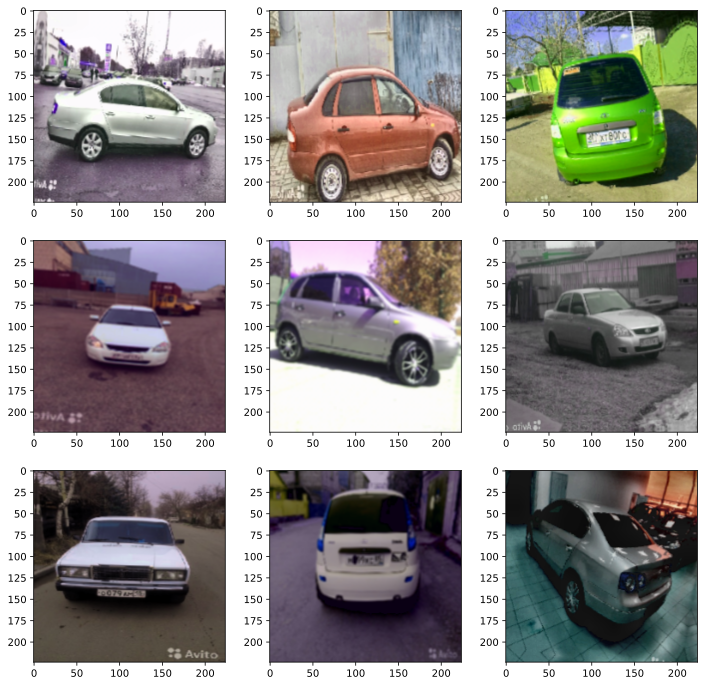

In [14]:
from skimage import io
 
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()
 
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,12))
 
for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели
Загружаем предобученную сеть Xception


In [15]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)

In [16]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

Строим модель

In [17]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.


In [18]:
checkpoint = ModelCheckpoint('best_model_{}.hdf5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

## Обучаем

In [19]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
827/827 [==============================] - ETA: 0s - loss: 1.5365 - accuracy: 0.4442
Epoch 00001: saving model to best_model_Xception.hdf5
827/827 [==============================] - 174s 211ms/step - loss: 1.5365 - accuracy: 0.4442 - val_loss: 1.3760 - val_accuracy: 0.4981
Epoch 2/10
827/827 [==============================] - ETA: 0s - loss: 1.3016 - accuracy: 0.5290
Epoch 00002: saving model to best_model_Xception.hdf5
827/827 [==============================] - 171s 207ms/step - loss: 1.3016 - accuracy: 0.5290 - val_loss: 1.2552 - val_accuracy: 0.5298
Epoch 3/10
827/827 [==============================] - ETA: 0s - loss: 1.2126 - accuracy: 0.5624
Epoch 00003: saving model to best_model_Xception.hdf5
827/827 [==============================] - 171s 207ms/step - loss: 1.2126 - accuracy: 0.5624 - val_loss: 1.1395 - val_accuracy: 0.5758
Epoch 4/10
827/827 [==============================] - ETA: 0s - loss:

In [20]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

In [21]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
146/146 [==============================] - 25s 173ms/step - loss: 1.0346 - accuracy: 0.6333
Accuracy: 63.33%


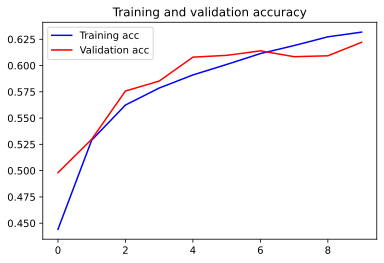

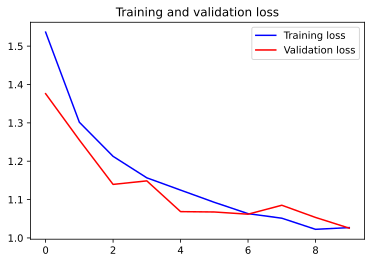

In [22]:
# Графики
make_graf(history)

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


Размораживаем имиджнет-модель частично (44 слоя размораживаем, 88 оставляем замороженными)

In [24]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 88

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Уменьшаем learning rate


In [25]:
LR=0.0005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Увеличиваем колиечество эпох обучения, т. к. уменьшили learnig rate


In [26]:
EPOCHS = 15
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/15
827/827 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.7163
Epoch 00001: saving model to best_model_Xception.hdf5
827/827 [==============================] - 173s 209ms/step - loss: 0.8096 - accuracy: 0.7163 - val_loss: 0.6261 - val_accuracy: 0.7759
Epoch 2/15
827/827 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8490
Epoch 00002: saving model to best_model_Xception.hdf5
827/827 [==============================] - 171s 207ms/step - loss: 0.4370 - accuracy: 0.8490 - val_loss: 0.4122 - val_accuracy: 0.8467
Epoch 3/15
827/827 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8790
Epoch 00003: saving model to best_model_Xception.hdf5
827/827 [==============================] - 172s 207ms/step - loss: 0.3410 - accuracy: 0.8790 - val_loss: 0.3844 - val_accuracy: 0.8673
Epoch 4/15
827/827 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9032
Epoch 00004: saving model to best_model_Xception.

In [27]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

In [28]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 25s 171ms/step - loss: 0.3041 - accuracy: 0.9098
Accuracy: 90.98%


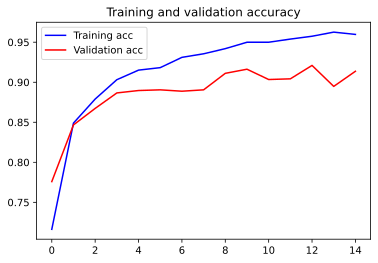

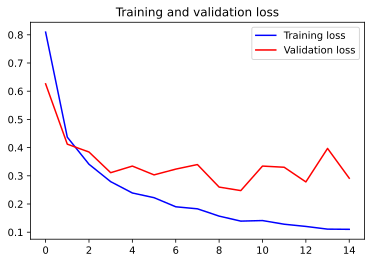

In [29]:
# Графики
make_graf(history)

Еще размораживаем имиджнет-модель частично (44 слоя размораживаем, 44 оставляем замороженными)

In [30]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 44

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Еще уменьшаем learning rate

In [31]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Еще увеличиваем колиечество эпох обучения


In [32]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
827/827 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9678
Epoch 00001: saving model to best_model_Xception.hdf5
827/827 [==============================] - 173s 209ms/step - loss: 0.0914 - accuracy: 0.9678 - val_loss: 0.2617 - val_accuracy: 0.9283
Epoch 2/20
827/827 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9772
Epoch 00002: saving model to best_model_Xception.hdf5
827/827 [==============================] - 172s 208ms/step - loss: 0.0649 - accuracy: 0.9772 - val_loss: 0.2220 - val_accuracy: 0.9343
Epoch 3/20
827/827 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9818
Epoch 00003: saving model to best_model_Xception.hdf5
827/827 [==============================] - 172s 208ms/step - loss: 0.0511 - accuracy: 0.9818 - val_loss: 0.2381 - val_accuracy: 0.9270
Epoch 4/20
827/827 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9859
Epoch 00005: saving model to best_model_Xception.

In [34]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 25s 170ms/step - loss: 0.3009 - accuracy: 0.9386
Accuracy: 93.86%


In [35]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

Окончательно размораживаем имиджнет-модель

In [36]:
base_model.trainable = True

Еще уменьшаем learning rate


In [37]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Еще увеличиваем колиечество эпох обучения

In [38]:
EPOCHS = 25
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/25
827/827 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9927
Epoch 00001: saving model to best_model_Xception.hdf5
827/827 [==============================] - 243s 294ms/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.2670 - val_accuracy: 0.9403
Epoch 2/25
827/827 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9951
Epoch 00002: saving model to best_model_Xception.hdf5
827/827 [==============================] - 242s 293ms/step - loss: 0.0139 - accuracy: 0.9951 - val_loss: 0.2722 - val_accuracy: 0.9420
Epoch 3/25
827/827 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9962
Epoch 00003: saving model to best_model_Xception.hdf5
827/827 [==============================] - 241s 292ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.2744 - val_accuracy: 0.9403
Epoch 4/25
508/827 [=================>............] - ETA: 1:22 - loss: 0.0090 - accuracy: 0.9972

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



827/827 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9968
Epoch 00009: saving model to best_model_Xception.hdf5
827/827 [==============================] - 241s 292ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.2772 - val_accuracy: 0.9455
Epoch 10/25
827/827 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9984
Epoch 00010: saving model to best_model_Xception.hdf5
827/827 [==============================] - 242s 293ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.2685 - val_accuracy: 0.9446
Epoch 11/25
827/827 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9983
Epoch 00011: saving model to best_model_Xception.hdf5
827/827 [==============================] - 242s 293ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.2750 - val_accuracy: 0.9450
Epoch 12/25
808/827 [============================>.] - ETA: 4s - loss: 0.0048 - accuracy: 0.9983

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



827/827 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9992
Epoch 00014: saving model to best_model_Xception.hdf5
827/827 [==============================] - 241s 292ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.2762 - val_accuracy: 0.9480
Epoch 15/25
827/827 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9988
Epoch 00015: saving model to best_model_Xception.hdf5
827/827 [==============================] - 241s 292ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.2674 - val_accuracy: 0.9493
Epoch 16/25
827/827 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988
Epoch 00016: saving model to best_model_Xception.hdf5
827/827 [==============================] - 242s 293ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.2697 - val_accuracy: 0.9511
Epoch 17/25
827/827 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9986
Epoch 00017: saving model to best_model_Xception.hdf5
827

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

In [40]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 25s 170ms/step - loss: 0.3019 - accuracy: 0.9480
Accuracy: 94.80%


## Step 2: Уменьшим значения аугментации, увеличим размер изображения


In [41]:
BATCH_SIZE = 4  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
IMG_SIZE = 512  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
LR=0.00001

In [42]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [139]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    '/work/train',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    '/work/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='/work/test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [44]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)

In [45]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Подгружаем веса

In [85]:
model.load_weights('best_model_Xception.hdf5')

Обучаем

In [86]:
EPOCHS = 15
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/15
3308/3308 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9633
Epoch 00001: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 631s 191ms/step - loss: 0.1186 - accuracy: 0.9633 - val_loss: 0.1129 - val_accuracy: 0.9678
Epoch 2/15
 970/3308 [=======>......................] - ETA: 7:07 - loss: 0.1071 - accuracy: 0.9678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3308/3308 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9736
Epoch 00004: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 632s 191ms/step - loss: 0.0832 - accuracy: 0.9736 - val_loss: 0.1149 - val_accuracy: 0.9704
Epoch 5/15
 139/3308 [>.............................] - ETA: 9:34 - loss: 0.0989 - accuracy: 0.9676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3308/3308 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9779
Epoch 00006: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 632s 191ms/step - loss: 0.0627 - accuracy: 0.9779 - val_loss: 0.1122 - val_accuracy: 0.9712
Epoch 7/15
2786/3308 [========================>.....] - ETA: 1:35 - loss: 0.0601 - accuracy: 0.9798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2913/3308 [=========================>....] - ETA: 1:12 - loss: 0.0503 - accuracy: 0.9841
Epoch 00008: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 631s 191ms/step - loss: 0.0518 - accuracy: 0.9834 - val_loss: 0.1207 - val_accuracy: 0.9717
Epoch 9/15
3308/3308 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9850
Epoch 00009: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 631s 191ms/step - loss: 0.0474 - accuracy: 0.9850 - val_loss: 0.1107 - val_accuracy: 0.9717
Epoch 10/15
1173/3308 [=========>....................] - ETA: 6:29 - loss: 0.0451 - accuracy: 0.9842

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3238/3308 [============================>.] - ETA: 12s - loss: 0.0370 - accuracy: 0.9885

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3308/3308 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9899
Epoch 00013: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 631s 191ms/step - loss: 0.0322 - accuracy: 0.9899 - val_loss: 0.1470 - val_accuracy: 0.9704
Epoch 14/15
3308/3308 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9915
Epoch 00014: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 629s 190ms/step - loss: 0.0300 - accuracy: 0.9915 - val_loss: 0.1513 - val_accuracy: 0.9678
Epoch 15/15
3308/3308 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9913
Epoch 00015: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 631s 191ms/step - loss: 0.0289 - accuracy: 0.9913 - val_loss: 0.1437 - val_accuracy: 0.9682


In [87]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

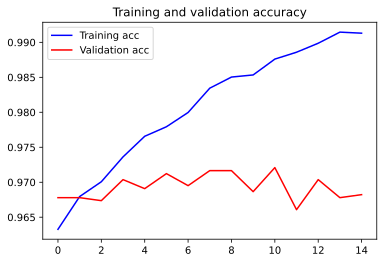

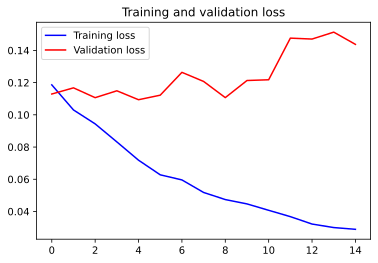

In [92]:
# Графики
make_graf(history)

Оценим метрику

In [93]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 26s 45ms/step - loss: 0.1139 - accuracy: 0.9596
Accuracy: 95.96%


## Предсказание на тестовых данных

In [98]:
test_sub_generator.samples

6675

In [99]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 195s 117ms/step


In [100]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [101]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


## Step 3: ТТА (Test Time Augmentation)

In [102]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

Работаем с тестовым датасетом

In [103]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [104]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='/work/test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


/usr/local/lib/python3.6/dist-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [105]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)


 440/1669 [======>.......................] - ETA: 2:25

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1669/1669 [==============================] - 196s 118ms/step


In [106]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [107]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('/work/test_upload/','')
submission.to_csv(f'submission_TTA_{part}.csv', index=False)
print('Save submit')

Save submit


### Вывод по данной части работы:

* Метрика на тесте: 97.04%
* Метрика на Kaggle: 97.07%
* Метрика с ТТА: 96.88%
* 38 Место на 26.04


## Попробуем построить модель на базе FixEfficientNetB0

In [108]:
BATCH_SIZE = 4  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
IMG_SIZE = 512  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
LR=0.00001
part = 'FixEfficientNetB0'  # Версия эксперимента

In [109]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [110]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    '/work/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    '/work/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='/work/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)



/usr/local/lib/python3.6/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [111]:
base_model = efn.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=input_shape)

In [112]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучаем

In [113]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
3308/3308 [==============================] - ETA: 0s - loss: 1.8112 - accuracy: 0.3801
Epoch 00001: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 628s 190ms/step - loss: 1.8112 - accuracy: 0.3801 - val_loss: 0.8368 - val_accuracy: 0.7746
Epoch 2/10
3308/3308 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.8202
Epoch 00003: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 628s 190ms/step - loss: 0.5401 - accuracy: 0.8202 - val_loss: 0.2215 - val_accuracy: 0.9279
Epoch 4/10
3308/3308 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8669
Epoch 00004: saving model to best_model_Xception.hdf5
3308/3308 [==============================] - 631s 191ms/step - loss: 0.4005 - accuracy: 0.8669 - val_loss: 0.1767 - val_accuracy: 0.9373
Epoch 5/10
3308/3308 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8953
Epoch 00005: saving model to best_m

In [114]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

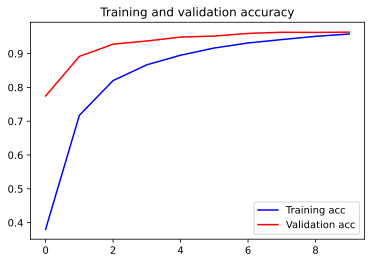

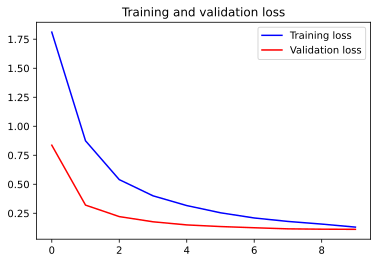

In [115]:
# Графики
make_graf(history)

In [116]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 26s 44ms/step - loss: 0.1171 - accuracy: 0.9596
Accuracy: 95.96%


In [117]:
## Предсказание на тестовых данных

In [140]:
test_sub_generator.samples

6675

In [119]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 195s 117ms/step


In [120]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [121]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


## ТТА (Test Time Augmentation)

In [122]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [123]:
# Работаем с тестовым датасетом

In [133]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,)

In [134]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='work/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 0 validated image filenames.


In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1363/1669 [=======================>......] - ETA: 35s

In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('/work/test_upload/','')
submission.to_csv(f'submission_TTA_{part}.csv', index=False)
print('Save submit')

### выводы:

* Метрика на тесте: 95.96%
* Метрика на Kaggle: 96.40%
* Метрика с ТТА: 96.74%


## Выводы по проекту:
* Итог 97.07%
* Протестировала имиджнет-модели - Xception, FixEfficientNetB0.
* Добавила Test Time Augmentation (TTA)